<a href="https://colab.research.google.com/github/Raoina/Spectra-2-Image/blob/main/notebooks/models/2d_CNN/2D_CNN_2_Channels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D-CNN pipeline (images ready)

In [ ]:
# ====== Imports ======
import os, random, gc
import numpy as np
import pandas as pd
from scipy.stats import iqr
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


After running the cell above and authorizing Colab to access your Google Drive, I will update the configuration with the correct paths to your data in Drive. Please provide the full paths to the image folder (MTF and GADF) and the CSV file within your Google Drive.

In [ ]:
# ====== Configuration ======
MTF_DIR = "/content/drive/MyDrive/MTF_65_Q_8"
GADF_DIR = "/content/drive/MyDrive/GADF_65_paa_norm"
CSV_PATH = "/content/target_train_700.csv"
TARGETS = ['Moi','NDF','Starch']
IMG_SIZE = 65

# Hyperparams
batch_size = 128
epochs = 100
lr = 1e-4
n_splits = 5
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
# ====== Load CSV ======
df = pd.read_csv(CSV_PATH)
df = df.dropna(subset=TARGETS).reset_index(drop=True)
print("CSV loaded:", df.shape)
# ====== Scale targets ======
y_scaler = StandardScaler()
targets_scaled = y_scaler.fit_transform(df[TARGETS].values.astype(np.float32))

CSV loaded: (784, 3)


In [ ]:
# ====== Dataset ======
class Soil2ChannelDataset(Dataset):
    def __init__(self, df, mtf_dir, gadf_dir, targets, transform=None):
        self.df = df
        self.mtf_dir = mtf_dir
        self.gadf_dir = gadf_dir
        self.targets = targets
        self.transform = transform if transform else transforms.ToTensor()

        self.mtf_files = sorted(os.listdir(mtf_dir))
        self.gadf_files = sorted(os.listdir(gadf_dir))

        # نتاكد ان العدد متساوي
        assert len(self.mtf_files) == len(self.gadf_files), \
            f"Mismatch between MTF ({len(self.mtf_files)}) and GADF ({len(self.gadf_files)}) counts!"

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        mtf_path = os.path.join(self.mtf_dir, self.mtf_files[idx])
        gadf_path = os.path.join(self.gadf_dir, self.gadf_files[idx])
        # channel grayscale
        mtf_img = Image.open(mtf_path).convert("L").resize((IMG_SIZE, IMG_SIZE))
        gadf_img = Image.open(gadf_path).convert("L").resize((IMG_SIZE, IMG_SIZE))

        mtf_tensor = self.transform(mtf_img)  # shape: (1,H,W)
        gadf_tensor = self.transform(gadf_img)

        # 2 channel image
        img_2ch = torch.cat([mtf_tensor, gadf_tensor], dim=0)  # shape: (2,H,W)

        target = torch.from_numpy(self.targets[idx])
        return img_2ch, target

In [ ]:
# ====== Transform ======
transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = Soil2ChannelDataset(df, MTF_DIR, GADF_DIR, targets_scaled, transform=transform)
print("Dataset length:", len(dataset))
print("Sample image shape:", dataset[0][0].shape)  # should be (2, IMG_SIZE, IMG_SIZE)


Dataset length: 784
Sample image shape: torch.Size([2, 65, 65])


In [ ]:
import torch
import torch.nn as nn

class CNN2D_2CH(nn.Module):
    def __init__(self, in_channels=2, num_outputs=3, img_size=65):
        super().__init__()
        # ====== Convolutional Layers ======
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4b = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5a = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5b = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        with torch.no_grad():
            sample = torch.zeros(1, in_channels, img_size, img_size)
            x = self.forward_features(sample)
            self.flattened = x.view(1, -1).shape[1]

        # ====== Fully Connected Layers ======
        self.fc1 = nn.Linear(self.flattened, 128)
        self.fc2 = nn.Linear(128, num_outputs)

    def forward_features(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        x = self.pool(x)
        x = self.relu(self.conv5a(x))
        x = self.relu(self.conv5b(x))
        x = self.pool(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

print("✅ CNN2D_2CH model ready (2-channel input).")


✅ CNN2D_2CH model ready (2-channel input).


In [ ]:
# ====== metrics helpers ======
def compute_metrics_orig(y_true, y_pred):
    results = []
    for i in range(y_true.shape[1]):
        yt, yp = y_true[:, i], y_pred[:, i]
        rmse = np.sqrt(mean_squared_error(yt, yp))
        r2 = r2_score(yt, yp)
        rpiq = float(iqr(yt) / rmse) if rmse > 1e-8 else float("inf")
        results.append({"RMSE": rmse, "R2": r2, "RPIQ": rpiq})
    return results

In [ ]:
# ====== train/val/test split indices (on dataset indices) ======
indices = np.arange(len(dataset))
trainval_idx, test_idx = train_test_split(indices, test_size=0.25, random_state=seed)
print("Train+Val samples:", len(trainval_idx), "Test samples:", len(test_idx))

Train+Val samples: 588 Test samples: 196



--- Fold 1/5 ---
Epoch 1/100, Loss: 0.97706
Epoch 10/100, Loss: 0.96369
Epoch 20/100, Loss: 0.95694
Epoch 30/100, Loss: 0.95292
Epoch 40/100, Loss: 0.96078
Epoch 50/100, Loss: 0.91460
Epoch 60/100, Loss: 0.88474
Epoch 70/100, Loss: 0.85782
Epoch 80/100, Loss: 0.84919
Epoch 90/100, Loss: 0.82146
Epoch 100/100, Loss: 0.82763
Fold 1 - Moi: RMSE=6.006, R2=0.094, RPIQ=1.128
Fold 1 - NDF: RMSE=5.819, R2=0.116, RPIQ=1.485
Fold 1 - Starch: RMSE=9.112, R2=0.195, RPIQ=1.192


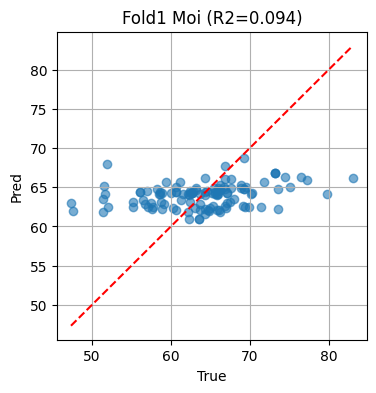

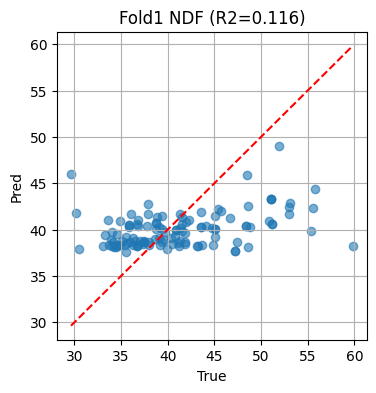

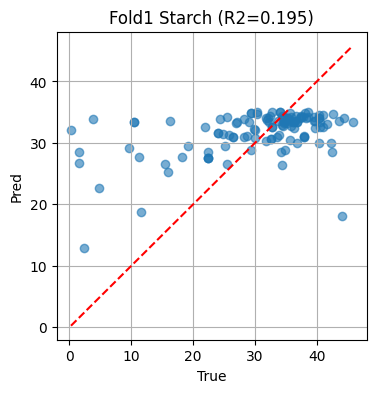


--- Fold 2/5 ---
Epoch 1/100, Loss: 0.98029
Epoch 10/100, Loss: 1.00913
Epoch 20/100, Loss: 0.99630
Epoch 30/100, Loss: 0.98624
Epoch 40/100, Loss: 0.97608
Epoch 50/100, Loss: 0.92684
Epoch 60/100, Loss: 0.87803
Epoch 70/100, Loss: 0.85734
Epoch 80/100, Loss: 0.81734
Epoch 90/100, Loss: 0.82280
Epoch 100/100, Loss: 0.78687
Fold 2 - Moi: RMSE=5.564, R2=0.028, RPIQ=1.388
Fold 2 - NDF: RMSE=5.619, R2=0.108, RPIQ=1.425
Fold 2 - Starch: RMSE=8.919, R2=0.158, RPIQ=1.182


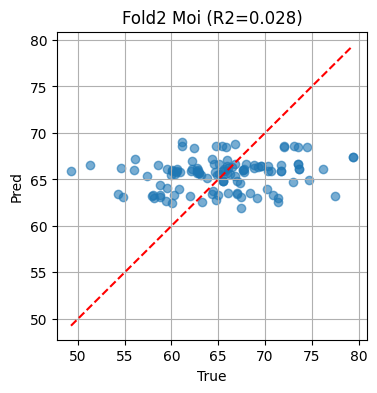

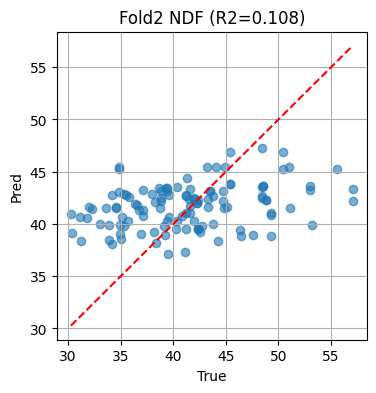

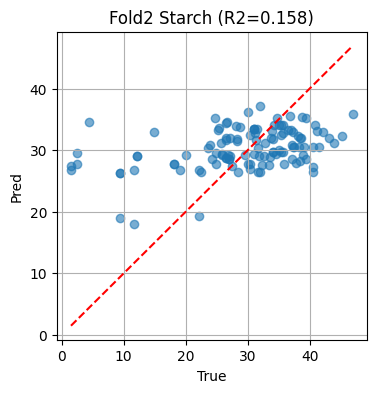


--- Fold 3/5 ---
Epoch 1/100, Loss: 0.97130
Epoch 10/100, Loss: 0.99928
Epoch 20/100, Loss: 0.98352
Epoch 30/100, Loss: 0.96555
Epoch 40/100, Loss: 0.90974
Epoch 50/100, Loss: 0.92662
Epoch 60/100, Loss: 0.89451
Epoch 70/100, Loss: 0.84699
Epoch 80/100, Loss: 0.81306
Epoch 90/100, Loss: 0.78959
Epoch 100/100, Loss: 0.76609
Fold 3 - Moi: RMSE=6.564, R2=0.016, RPIQ=0.931
Fold 3 - NDF: RMSE=6.237, R2=-0.290, RPIQ=1.100
Fold 3 - Starch: RMSE=9.913, R2=-0.066, RPIQ=0.886


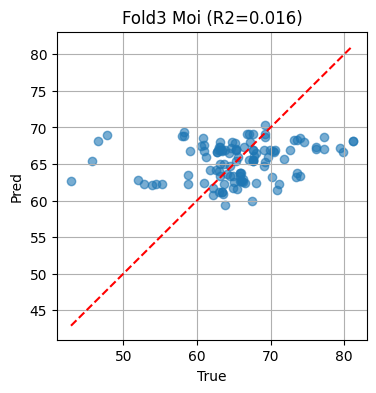

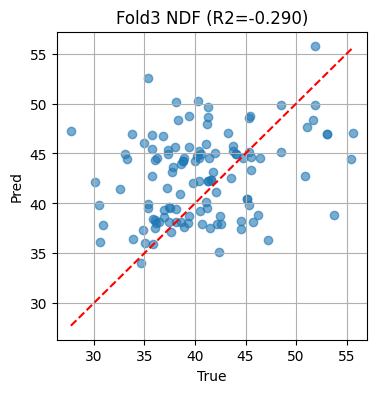

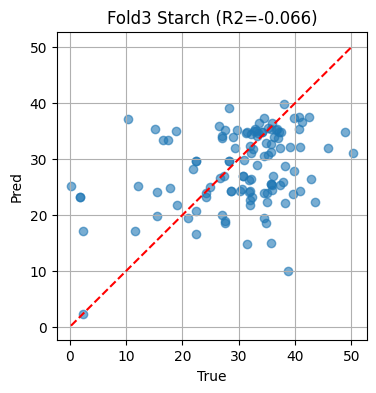


--- Fold 4/5 ---
Epoch 1/100, Loss: 0.96041
Epoch 10/100, Loss: 0.94423
Epoch 20/100, Loss: 0.95722
Epoch 30/100, Loss: 0.90890
Epoch 40/100, Loss: 0.88218
Epoch 50/100, Loss: 0.87624
Epoch 60/100, Loss: 0.85336
Epoch 70/100, Loss: 0.79746
Epoch 80/100, Loss: 0.78511
Epoch 90/100, Loss: 0.74629
Epoch 100/100, Loss: 0.74818
Fold 4 - Moi: RMSE=6.314, R2=-0.274, RPIQ=1.129
Fold 4 - NDF: RMSE=7.581, R2=-0.081, RPIQ=0.838
Fold 4 - Starch: RMSE=9.607, R2=-0.099, RPIQ=1.122


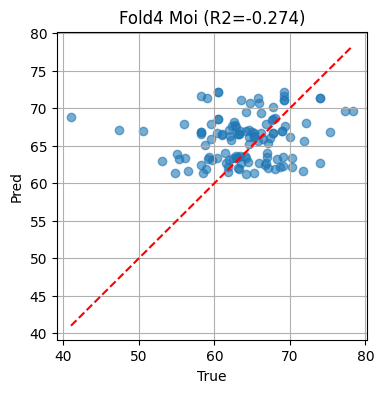

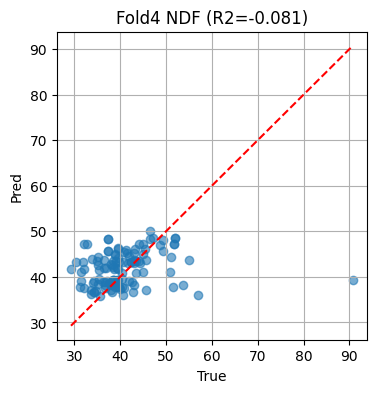

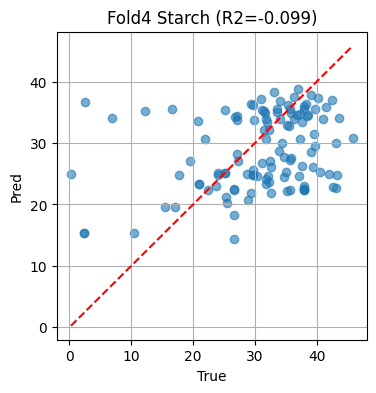


--- Fold 5/5 ---
Epoch 1/100, Loss: 0.94282
Epoch 10/100, Loss: 0.94830
Epoch 20/100, Loss: 0.93028
Epoch 30/100, Loss: 0.93749
Epoch 40/100, Loss: 0.90463
Epoch 50/100, Loss: 0.89523
Epoch 60/100, Loss: 0.85484
Epoch 70/100, Loss: 0.86310
Epoch 80/100, Loss: 0.83435
Epoch 90/100, Loss: 0.77995
Epoch 100/100, Loss: 0.71230
Fold 5 - Moi: RMSE=6.292, R2=0.020, RPIQ=1.131
Fold 5 - NDF: RMSE=6.380, R2=0.042, RPIQ=1.097
Fold 5 - Starch: RMSE=10.400, R2=0.081, RPIQ=0.988


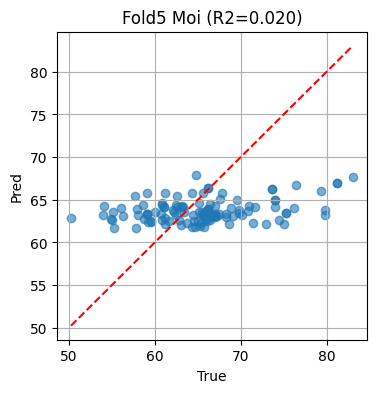

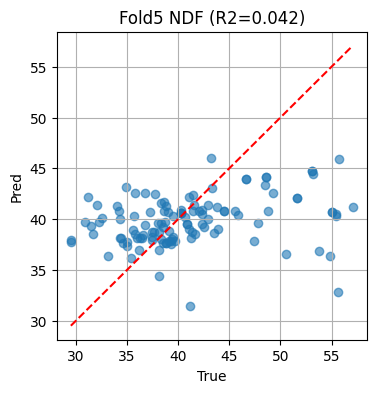

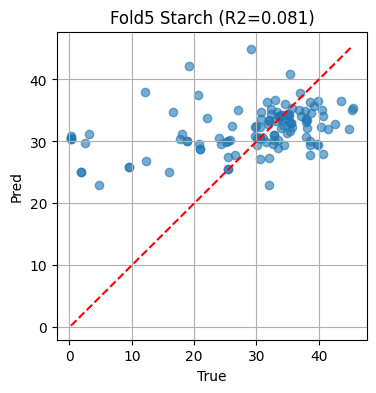

In [ ]:
# ====== 5-Fold CV (collect predictions across folds) ======
kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

# storage across folds
cv_true_all = []   # list of arrays (per fold)
cv_pred_all = []
fold_metrics_list = []

for fold, (t_idx, v_idx) in enumerate(kf.split(trainval_idx)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")
    # create subset indices for DataLoader (use actual indices in dataset)
    train_subset_idx = trainval_idx[t_idx]
    val_subset_idx = trainval_idx[v_idx]

    train_loader = DataLoader(Subset(dataset, train_subset_idx), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(Subset(dataset, val_subset_idx), batch_size=batch_size, shuffle=False)

    model = CNN2D_2CH().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Training
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()
        if (epoch+1) % 10 == 0 or epoch==0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.5f}")

    # Validation: collect predictions and inverse-transform
    model.eval()
    y_true_fold, y_pred_fold = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            preds = model(xb).cpu().numpy()
            yb_np = yb.cpu().numpy()
            preds_orig = y_scaler.inverse_transform(preds)
            yb_orig = y_scaler.inverse_transform(yb_np)
            y_true_fold.append(yb_orig)
            y_pred_fold.append(preds_orig)

    y_true_fold = np.vstack(y_true_fold)
    y_pred_fold = np.vstack(y_pred_fold)

    # store for aggregated CV metrics/plots
    cv_true_all.append(y_true_fold)
    cv_pred_all.append(y_pred_fold)

    metrics = compute_metrics_orig(y_true_fold, y_pred_fold)
    fold_metrics_list.append(metrics)

    # print per-target metrics for this fold
    for i, tname in enumerate(TARGETS):
        print(f"Fold {fold+1} - {tname}: RMSE={metrics[i]['RMSE']:.3f}, R2={metrics[i]['R2']:.3f}, RPIQ={metrics[i]['RPIQ']:.3f}")

    # quick scatter per target in fold (optional)
    for i, tname in enumerate(TARGETS):
        plt.figure(figsize=(4,4))
        plt.scatter(y_true_fold[:, i], y_pred_fold[:, i], alpha=0.6)
        mn, mx = y_true_fold[:, i].min(), y_true_fold[:, i].max()
        plt.plot([mn,mx],[mn,mx],'r--')
        plt.xlabel("True"); plt.ylabel("Pred")
        plt.title(f"Fold{fold+1} {tname} (R2={metrics[i]['R2']:.3f})")
        plt.grid(True)
        plt.show()

    # cleanup
    del model, optimizer
    gc.collect()
    torch.cuda.empty_cache()


In [ ]:
# ====== Aggregate CV results across folds ======
cv_true_all = np.vstack(cv_true_all)
cv_pred_all = np.vstack(cv_pred_all)
cv_metrics = compute_metrics_orig(cv_true_all, cv_pred_all)

print("\n=== Aggregated CV metrics (all folds combined) ===")
for i, tname in enumerate(TARGETS):
    print(f"{tname}: RMSE={cv_metrics[i]['RMSE']:.3f}, R2={cv_metrics[i]['R2']:.3f}, RPIQ={cv_metrics[i]['RPIQ']:.3f}")



=== Aggregated CV metrics (all folds combined) ===
Moi: RMSE=6.157, R2=0.002, RPIQ=1.090
NDF: RMSE=6.362, R2=-0.013, RPIQ=1.165
Starch: RMSE=9.604, R2=0.066, RPIQ=1.071


In [ ]:
# ====== Train final model on whole trainval and evaluate on test ======
final_loader = DataLoader(Subset(dataset, trainval_idx), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(Subset(dataset, test_idx), batch_size=batch_size, shuffle=False)

final_model = CNN2D_2CH().to(device)
optimizer = torch.optim.Adam(final_model.parameters(), lr=lr)
criterion = nn.MSELoss()

for epoch in range(epochs):
    final_model.train()
    epoch_loss = 0.0
    for xb, yb in final_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = final_model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if (epoch+1) % 10 == 0 or epoch==0:
        print(f"Final training epoch {epoch+1}/{epochs}, loss: {epoch_loss/len(final_loader):.5f}")


Final training epoch 1/100, loss: 0.96300
Final training epoch 10/100, loss: 0.98462
Final training epoch 20/100, loss: 0.95058
Final training epoch 30/100, loss: 0.91212
Final training epoch 40/100, loss: 0.89193
Final training epoch 50/100, loss: 0.83652
Final training epoch 60/100, loss: 0.96044
Final training epoch 70/100, loss: 0.94610
Final training epoch 80/100, loss: 0.84531
Final training epoch 90/100, loss: 0.84081
Final training epoch 100/100, loss: 0.76228


In [ ]:
# Evaluate on test set
final_model.eval()
y_true_test_list, y_pred_test_list = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = final_model(xb).cpu().numpy()
        yb_np = yb.cpu().numpy()
        preds_orig = y_scaler.inverse_transform(preds)
        yb_orig = y_scaler.inverse_transform(yb_np)
        y_true_test_list.append(yb_orig)
        y_pred_test_list.append(preds_orig)

y_true_test = np.vstack(y_true_test_list)
y_pred_test = np.vstack(y_pred_test_list)

test_metrics = compute_metrics_orig(y_true_test, y_pred_test)
print("\n=== Test metrics ===")
for i, tname in enumerate(TARGETS):
    print(f"{tname}: RMSE={test_metrics[i]['RMSE']:.3f}, R2={test_metrics[i]['R2']:.3f}, RPIQ={test_metrics[i]['RPIQ']:.3f}")

    # plot
    plt.figure(figsize=(5,5))
    plt.scatter(y_true_test[:, i], y_pred_test[:, i], alpha=0.6)
    mn, mx = y_true_test[:, i].min(), y_true_test[:, i].max()
    plt.plot([mn,mx],[mn,mx],'r--')
    plt.xlabel("True"); plt.ylabel("Pred")
    plt.title(f"Test {tname} (R2={test_metrics[i]['R2']:.3f})")
    plt.grid(True)
    plt.show()

Target: Moi, Min: 41.001, Max: 83.060
Target: NDF, Min: 26.690, Max: 90.740
Target: Starch, Min: 0.250, Max: 50.800


In [ ]:
# ====== Save final model ======
save_path = f"/content/{plot_name}_final_model.pth"
torch.save(final_model.state_dict(), save_path)
print("Saved final model to:", save_path)

Target: Moi, Min: 41.001, Max: 83.060
Target: NDF, Min: 26.690, Max: 90.740
Target: Starch, Min: 0.250, Max: 50.800


In [ ]:

# ====== Print min/max for each target (original df) ======
print("\n=== Targets min/max (from CSV) ===")
for t in TARGETS:
    print(f"{t}: Min={df[t].min():.3f}, Max={df[t].max():.3f}")